In [25]:
# data source
data_file = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/version2_login/experiment/ato_login_sample_feature_v2_1657164305662.txt'
# define venture, entrance (all entrance)
venture = 'ID'


# define whether to display feature importance, shap or PR curve on test data
is_grid_search, is_feature_importance, is_shap, is_plot_pr = True, True, True, True
# define whether to skip some sections, False means do not run that part
is_save_model, is_plot_interactive_pr, is_plot_thrhld_bin, is_comparision_w_old_model = False, True, True, True

# model feature list
features_to_use = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'id_new_ip3_4m',
                  'id_ip3_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_14d',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_14d'
                     ]

features_type = [False,
                 False,
                 True,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False,
                 False,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False
                ]

byr_idx_cols = ['label', 'buyer_id']

# feature list that needs to impute
features_to_impute = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'id_new_ip3_4m',
                  'id_ip3_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_14d',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_14d'
                     ]

model_list = ['rf', 'xgb']


# params of model
rf_default_param = {'bootstrap': True, 'oob_score': True, 'max_depth':10, 'n_estimators': 120, 'criterion':'gini',
             'n_jobs': -1, 'random_state': 0
               , 'class_weight': 'balanced'
            }

rf_param_grid = {
            'max_depth': [2, 8, 16],
            'n_estimators': [32, 64, 128],
            'min_samples_leaf' : [5, 20, 30],
            'bootstrap': [True], 
            'oob_score': [True], 
            'criterion':['gini'],
            'random_state': [0], 
            'class_weight': ['balanced']
            }    

xgb_default_param = {'verbosity':0, 'n_jobs': -1, 'random_state':0}
xgb_param_grid = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 5, 10],
            'verbosity':[0],
            'use_label_encoder':[False],
            'random_state': [0]
            }              

model_params = {'rf': [rf_default_param, rf_param_grid],
                'xgb': [xgb_default_param, xgb_param_grid]
               }

# seed for generating the training / testing set
random_state = 42
test_size = 0.2
cv = 5
threshold_setting = 0.5

# best parameters

In [39]:
%pip install xgboost
%pip install shap
%pip install plotly
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px

import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
import shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Functions

In [40]:
# define function to reduce data size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df




# define function to plot PR curve
def plot_pr(y, pred):
    # based on different thresholds
    precision, recall, thresholds = precision_recall_curve(y, pred)

    f1_scores = []
    for i in range(len(thresholds)):
        f1_scores.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
    
    # select the best model according to the f1-score
    ix = np.argmax(f1_scores)
#     print('Best threshold: ', thresholds[ix])
#     print('Best F1-Score: ', np.max(f1_scores))

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best')

    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

    return thresholds[ix], precision, recall, thresholds, f1_scores


# display the distribution of features
# col2 represents the label
# col1 reprensts the features
def display_kdeplot(df, col1, col2, is_cat):
    df[col1] = df[col1].astype(float)
    plt.figure(figsize = (15, 6))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
    else:
        ax = plt.axes()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, color = 'darkorange', label = 'Non-ATO')
        ax_bis = ax.twinx()
        sns.kdeplot(data = df[df[col2] == 1], x = col1, label = 'ATO')
        plt.title(col1)
        ax.legend(loc = 'upper left')
        ax_bis.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show
    
    print(df.groupby(col2)[col1].describe())
    print(col1)
    
##----------------------------------------------------------------------------------------------------
def train_test_generation(df, features_to_use, byr_idx_cols, test_size, random_state):
    feature_list = byr_idx_cols + features_to_use
    # only select the features we need
    df = df[feature_list].astype(float)
    
    y = df['label']
    
    df_train, df_test, y_train, y_test = train_test_split(df, y, test_size = test_size, random_state = random_state)
    
    X_train, X_test = df_train[features_to_use], df_test[features_to_use]
    
    return X_train, y_train, X_test, y_test, df_test

def display_model_metrics(y, y_pred):
    print('     F1 score:', f1_score(y, y_pred))
    print('     AUC:', roc_auc_score(y, y_pred))
    print('     Accuracy:', accuracy_score(y, y_pred))
    print('     Precision:', precision_score(y, y_pred))
    print('     Recall:', recall_score(y, y_pred))
    print("\tConfusion matrix：\n", confusion_matrix(y, y_pred))
    
# model grid search method
def model_grid_search(is_grid_search, clf_gs, param_grid, default_param, cv, x, y):
    if is_grid_search:
        grid_search = GridSearchCV(estimator = clf_gs,
                                  param_grid = param_grid,
                                  scoring = 'roc_auc',
                                  cv = cv,
                                  verbose = 1,
                                  n_jobs = 1
                                  )
        grid_search.fit(x, y)
        best_param = grid_search.best_params_
    else:
        best_param = default_param
        
    print('====> grid search parameters: \n{')
    [print(key,':',value) for key, value in param_grid.items()]
    print('}\n')
        
    print('====> best estimator: \n{')
    [print(key,':',value) for key, value in best_param.items()]
    print('}\n')
    
    return best_param


# model training process    
def model_train(mod, X_train, y_train, X_test, y_test, 
                threshold, features_to_use,
                is_feature_importance, is_shap, is_plot_pr):
    
    mod.fit(X_train, y_train)
    
    # model prediction on training set
    y_train_preds = mod.predict(X_train)
    y_train_preds_prob = mod.predict_proba(X_train)
    train_preds = [1 if y_train_preds_prob[i][1] > threshold else 0 for i in range(len(y_train_preds_prob))]
    print("=============================================================")
    print(f'Train:')
    print('Label distribution:\n{}\n'.format(y_train.value_counts()))
    display_model_metrics(y_train, train_preds)
    
    # model prediction on testing set
    y_test_preds = mod.predict(X_test)
    y_test_preds_prob = mod.predict_proba(X_test)
    test_preds = [1 if y_test_preds_prob[i][1] > threshold else 0 for i in range(len(y_test_preds_prob))]
    print("\n=============================================================")
    print('Testing:')
    print('Label distribution:\n{}\n'.format(y_test.value_counts()))
    display_model_metrics(y_test, test_preds)
    
    output_list = [mod]

    
    # feature importance
    if is_feature_importance is True:
        print("=============================================================")
        print(pd.DataFrame({'feature': list(features_to_use),
               'importance': mod.feature_importances_}).\
                sort_values('importance', ascending = False))
    # shapley value
    if is_shap is True:
        print("=============================================================")
        print('SHAP explanation: \n')
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_test)
        try: 
            shap.summary_plot(shap_values[1], X_test, max_display=30)
        except:
            shap.summary_plot(shap_values, X_test, max_display=30)
    # precision-recall curve
    if is_plot_pr is True:
        print("=============================================================")
        thres, precision, recall, thresholds, f1_scores = plot_pr(y_test, y_test_preds_prob[:, 1])
        output_list.append([thres, precision, recall, thresholds, f1_scores])
    
    output_list.append(y_test_preds_prob[:,1])
    
    return output_list


# main function
# main function to run model and display result reports
def run_model(df, features_to_use, byr_idx_cols, cv,
              model_name, model_param, threshold, 
              is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state):
    
    X_train, y_train, X_test, y_test, df_test = train_test_generation(df, features_to_use, byr_idx_cols,
                                                                test_size, random_state)
    
    
    # model training
    x, y = X_train, y_train

    # RF
    if model_name == 'rf':
        print('=============================================================')
        print('                    Random forest model                      ')
        print('=============================================================')
        
        # grid search
        clf_gs = RandomForestClassifier()
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = RandomForestClassifier(**best_param)
        
    # xgboost
    elif model_name == 'xgb':
        print('=============================================================')
        print('                      Xgboost model                          ')
        print('=============================================================')
        # grid search
        clf_gs = xgb.XGBClassifier()   
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = xgb.XGBClassifier(**best_param)   
        
                
    output_list = model_train(clf, X_train, y_train, X_test, y_test, threshold,
                                  features_to_use, is_feature_importance, is_shap, is_plot_pr,
                                 )

    return output_list

# 1. Load data

In [6]:
df = pd.read_csv(data_file, delimiter = ',', dtype = str)
df['label'] = df['label'].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d
0,10608942,0.0,2,4,1,0,\N,\N,\N,\N,\N,\N,\N,0,\N,\N,\N,\N
1,10779984,0.0,2,1,0,0,34900.0,0.0,0.0,0.0,6900.0,0.0,0,1,0.11202735317779565,12092.021107862378,0.5768609158123034,2956.9723234669764
2,1124333,0.0,1,1,1,0,182.57142857142858,61.985844335293066,0.0,0.0,48.42857142857143,15.927129979621409,\N,1,\N,\N,\N,\N
3,11289976,0.0,0,0,0,0,\N,\N,\N,\N,\N,\N,\N,1,\N,\N,\N,\N
4,11721883,0.0,2,5,0,0,45466.5,5233.5,0.0,0.0,6900.0,0.0,0,1,0.12882402469828796,41695.30326797385,0.7412961020572922,16773.2091503268


In [7]:
# 2.impute null values with 0
df = df.replace('\\N', 0)
df[features_to_impute] = df[features_to_impute].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d
0,10608942,0.0,2.0,4.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,10779984,0.0,2.0,1.0,0.0,0.0,34900.000000,0.000000,0.0,0.0,6900.000000,0.00000,0.0,1.0,0.112027,12092.021108,0.576861,2956.972323
2,1124333,0.0,1.0,1.0,1.0,0.0,182.571429,61.985844,0.0,0.0,48.428571,15.92713,0.0,1.0,0.000000,0.000000,0.000000,0.000000
3,11289976,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
4,11721883,0.0,2.0,5.0,0.0,0.0,45466.500000,5233.500000,0.0,0.0,6900.000000,0.00000,0.0,1.0,0.128824,41695.303268,0.741296,16773.209150


In [8]:
# Calculate percent of black samples
bl_cnt = (df.label==1).astype(float).sum()
total = (df.label!=-1).astype(float).sum()
percent = round((bl_cnt / total)*100, 2)

print(bl_cnt, 'black samples out of a total of', total, 'samples.')
print('Black sample percent: ' +  str(percent) + '%')

1155.0 black samples out of a total of 2655.0 samples.
Black sample percent: 43.5%


In [9]:
df_feature = reduce_mem_usage(df)

Memory usage of dataframe is 0.36 MB
Memory usage after optimization is: 0.20 MB
Decreased by 43.8%


In [17]:
df_feature.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d
0,10608942,0.0,2.0,4.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,10779984,0.0,2.0,1.0,0.0,0.0,34900.000000,0.000000,0.0,0.0,6900.00000,0.00000,0.0,1.0,0.112000,12092.021484,0.576660,2956.972412
2,1124333,0.0,1.0,1.0,1.0,0.0,182.571426,61.985844,0.0,0.0,48.42857,15.92713,0.0,1.0,0.000000,0.000000,0.000000,0.000000
3,11289976,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
4,11721883,0.0,2.0,5.0,0.0,0.0,45466.500000,5233.500000,0.0,0.0,6900.00000,0.00000,0.0,1.0,0.128784,41695.304688,0.741211,16773.208984


# 2. visualization

In [11]:
# check unique value count within every feature
pd.set_option('display.max_rows', 200)
df_feature[features_to_use].apply(pd.Series.nunique)

no_unique_umid_14d                 14
no_unique_ip2_14d                  10
id_new_ip3_4m                       2
id_ip3_same_seller_14d              2
avg_price_per_order_14d          1560
std_price_per_order_14d          1060
avg_dscnt_rate_per_order_14d      454
std_dscnt_rate_per_order_14d      345
avg_shpfee_per_order_14d          948
std_shpfee_per_order_14d          863
id_susp_paymethod_14d               2
no_acct_umid_14d                   81
max_cancel_rate_14d               673
max_avg_price_seller_14d         1517
max_avg_dscnt_rate_seller_14d     889
max_avg_shpfee_seller_14d        1341
dtype: int64

        count      mean       std  min  25%  50%  75%   max
label                                                      
0.0    1500.0  0.808667  1.277946  0.0  0.0  1.0  1.0  19.0
1.0    1155.0  1.093506  0.430530  0.0  1.0  1.0  1.0   5.0
no_unique_umid_14d
------------------------------------------------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    1500.0  1.115333  1.273491  0.0  0.0  1.0  2.0  8.0
1.0    1155.0  2.665801  1.477444  0.0  2.0  2.0  4.0  9.0
no_unique_ip2_14d
------------------------------------------------------------------------
        count     mean       std  min  25%  50%  75%  max
label                                                    
0.0    1500.0  0.59200  0.491627  0.0  0.0  1.0  1.0  1.0
1.0    1155.0  0.92381  0.265418  0.0  1.0  1.0  1.0  1.0
id_new_ip3_4m
------------------------------------------------------------------------
        count      mea

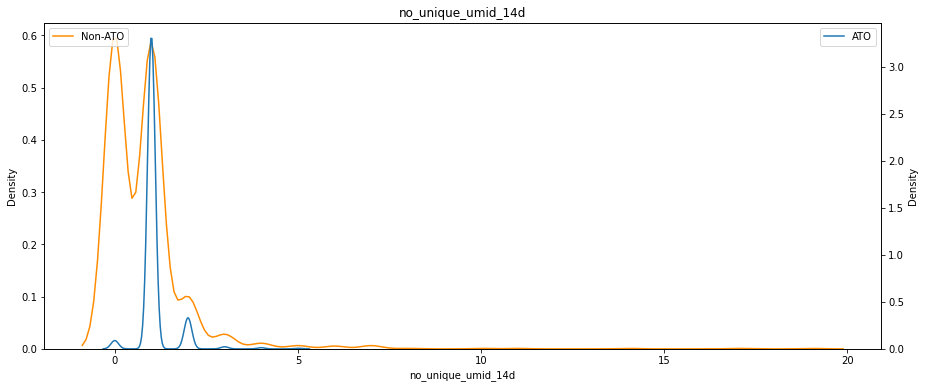

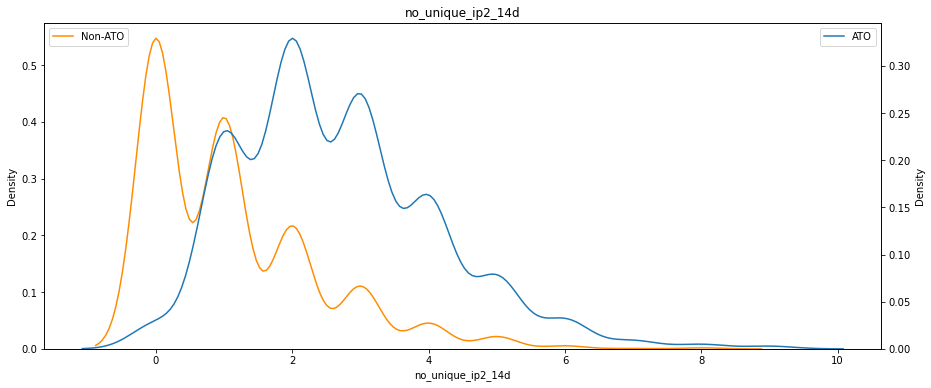

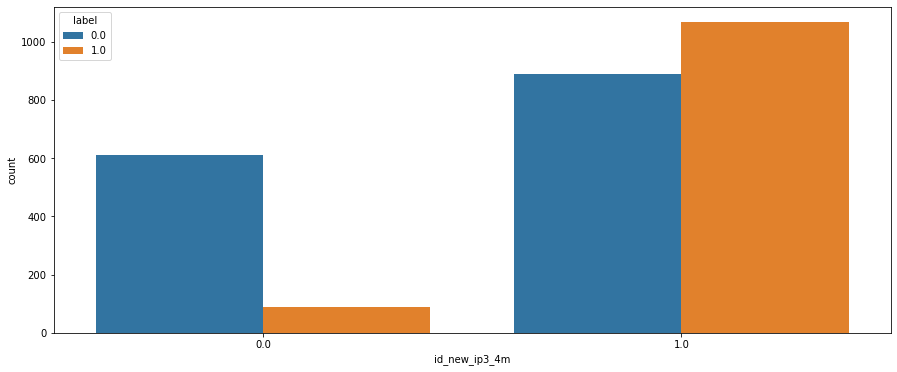

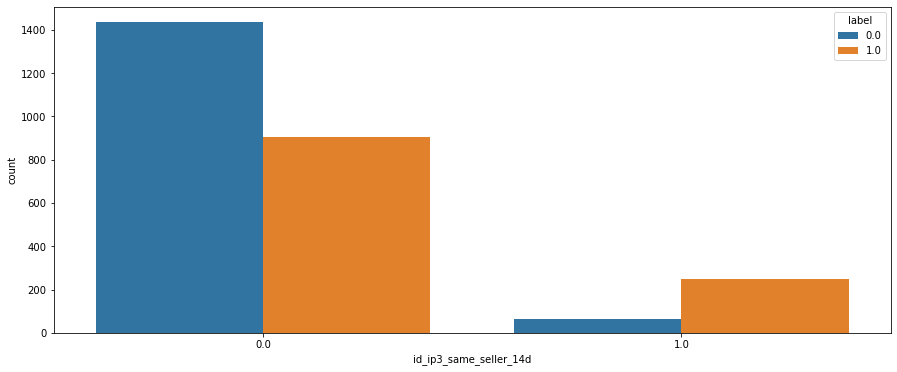

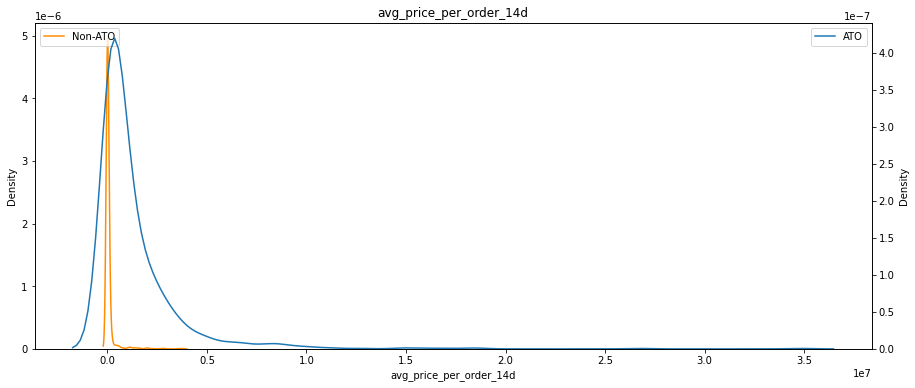

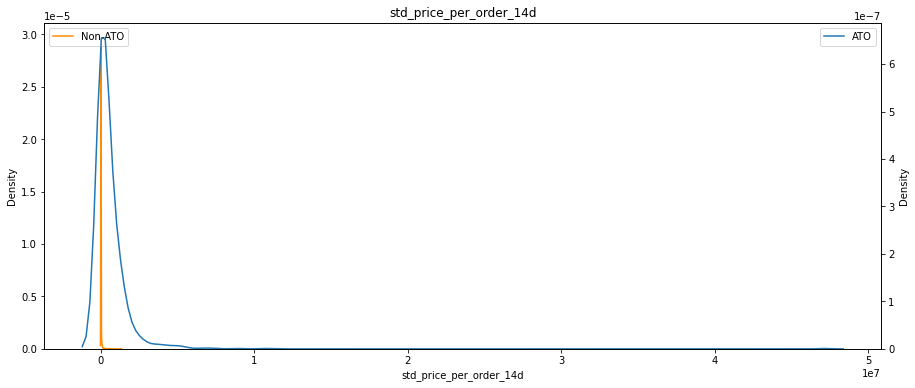

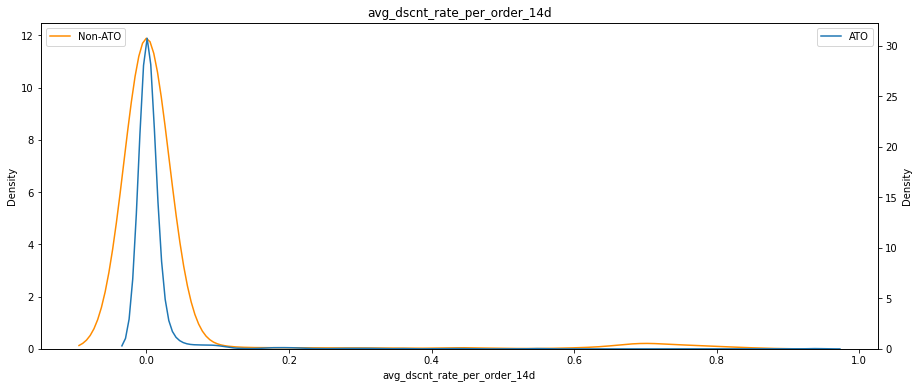

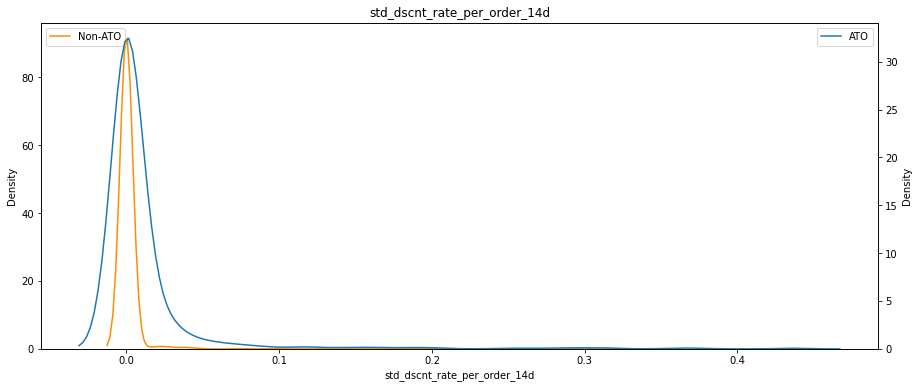

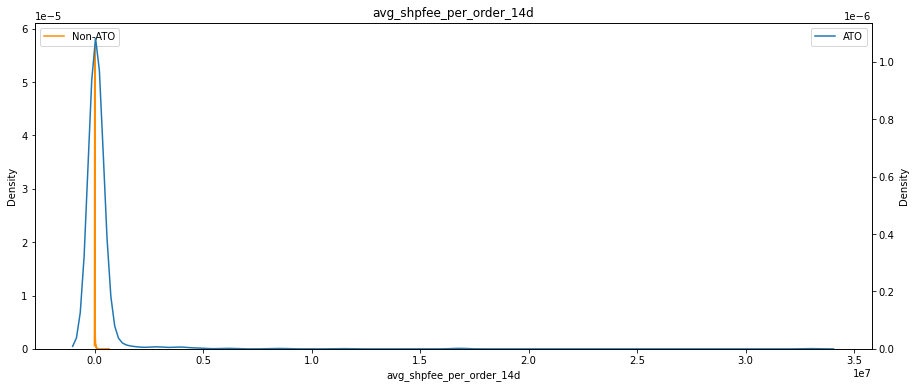

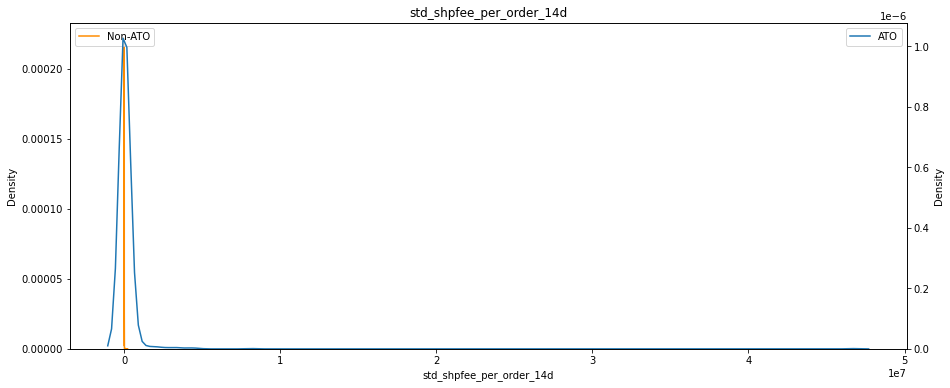

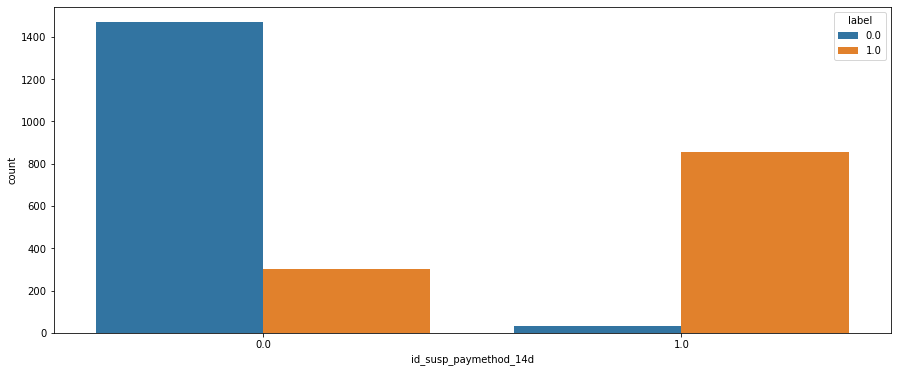

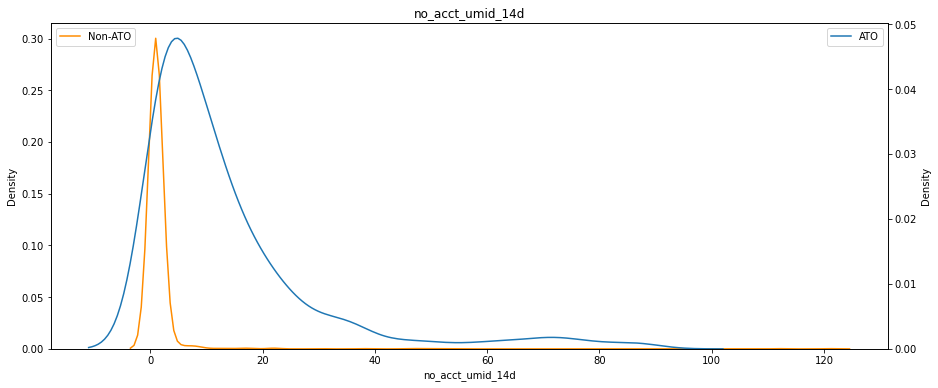

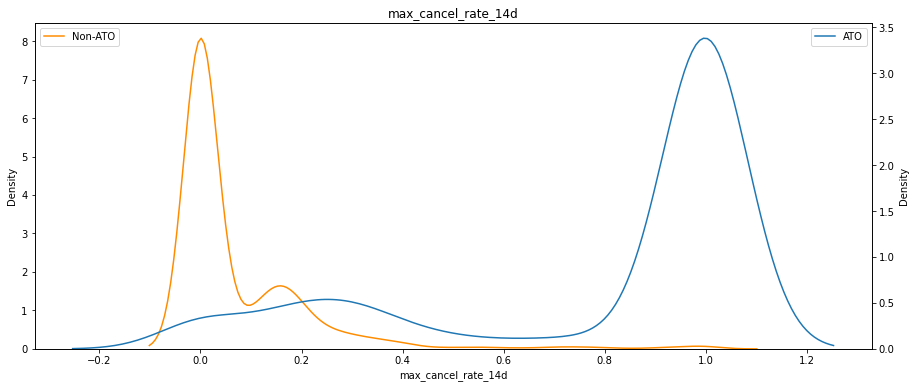

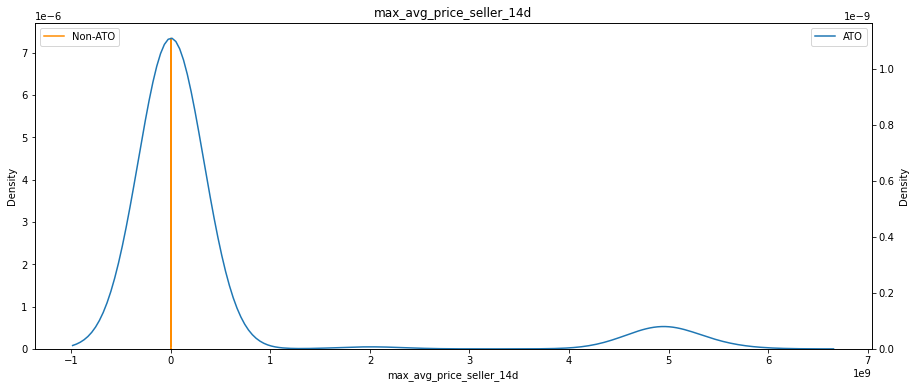

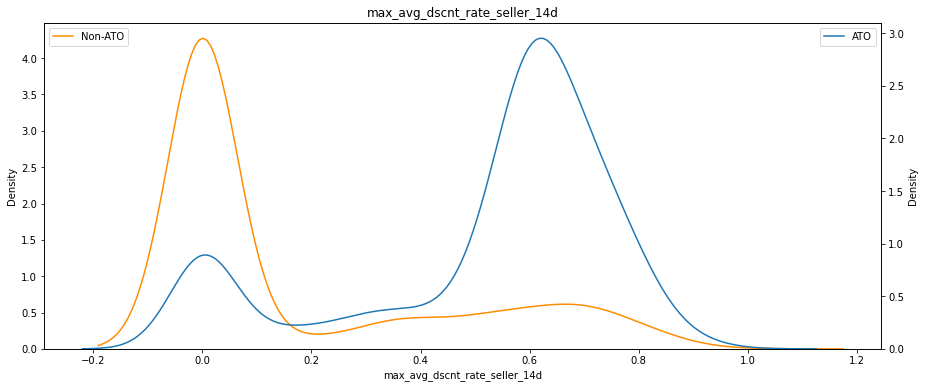

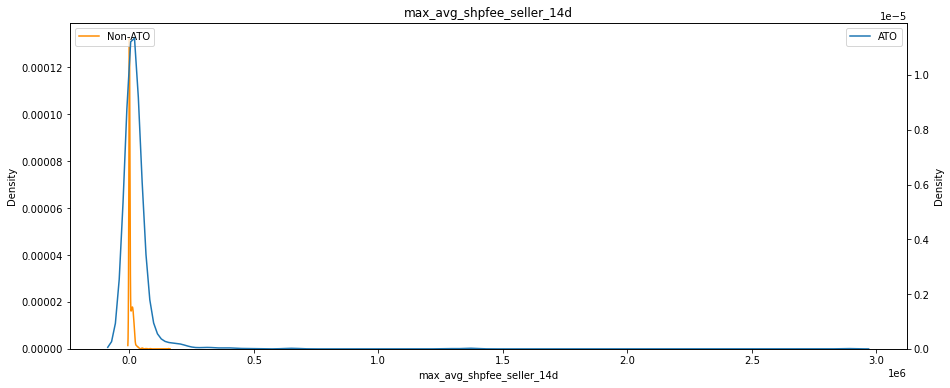

In [41]:
for i in range(len(features_to_use)):
    feature_name = features_to_use[i]
    feature_type = features_type[i]
    display_kdeplot(df_feature, feature_name, 'label', feature_type)
    print('------------------------------------------------------------------------')

# 3. Model training

                    Random forest model                      
Fitting 5 folds for each of 27 candidates, totalling 135 fits
====> grid search parameters: 
{
max_depth : [2, 8, 16]
n_estimators : [32, 64, 128]
min_samples_leaf : [5, 20, 30]
bootstrap : [True]
oob_score : [True]
criterion : ['gini']
random_state : [0]
class_weight : ['balanced']
}

====> best estimator: 
{
bootstrap : True
class_weight : balanced
criterion : gini
max_depth : 8
min_samples_leaf : 5
n_estimators : 128
oob_score : True
random_state : 0
}

Train:
Label distribution:
0.0    1193
1.0     931
Name: label, dtype: int64

     F1 score: 0.9683060109289618
     AUC: 0.9703839889509428
     Accuracy: 0.972693032015066
     Precision: 0.985539488320356
     Recall: 0.9516648764769066
	Confusion matrix：
 [[1180   13]
 [  45  886]]

Testing:
Label distribution:
0.0    307
1.0    224
Name: label, dtype: int64

     F1 score: 0.9272727272727271
     AUC: 0.9358131689157747
     Accuracy: 0.9397363465160076
     Precision

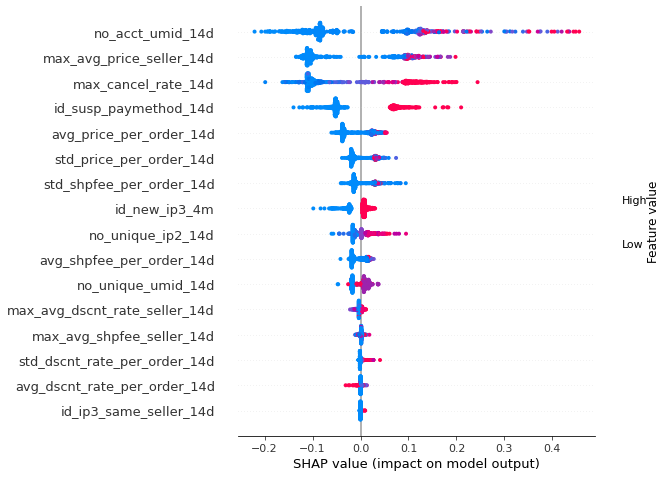

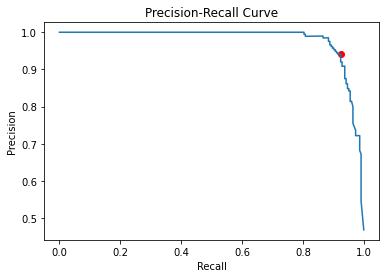

                      Xgboost model                          
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
====> grid search parameters: 
{
min_child_weight : [1, 5, 10]
gamma : [0.5, 1, 1.5, 2, 5]
subsample : [0.6, 0.8, 1.0]
colsample_bytree : [0.6, 0.8, 1.0]
max_depth : [3, 5, 10]
verbosity : [0]
use_label_encoder : [False]
random_state : [0]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 0.5
max_depth : 10
min_child_weight : 1
random_state : 0
subsample : 1.0
use_label_encoder : False
verbosity : 0
}

Train:
Label distribution:
0.0    1193
1.0     931
Name: label, dtype: int64

     F1 score: 0.985854189336235
     AUC: 0.9861544653154861
     Accuracy: 0.987758945386064
     Precision: 0.9988974641675854
     Recall: 0.9731471535982814
	Confusion matrix：
 [[1192    1]
 [  25  906]]

Testing:
Label distribution:
0.0    307
1.0    224
Name: label, dtype: int64

     F1 score: 0.9387755102040817
     AUC: 0.9457669264774313
     Accuracy: 0.9491525423728

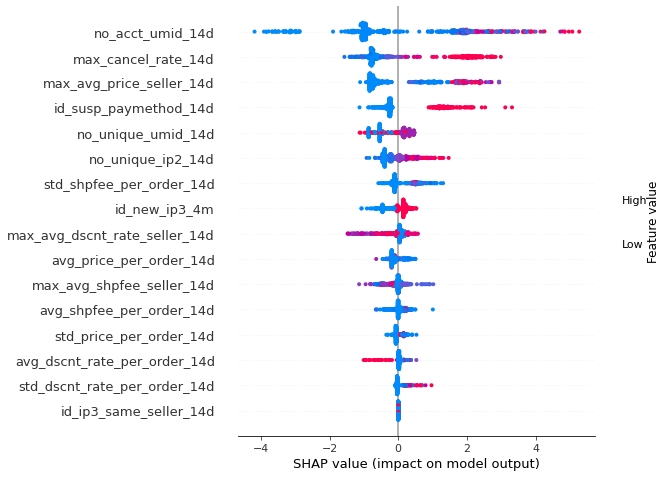

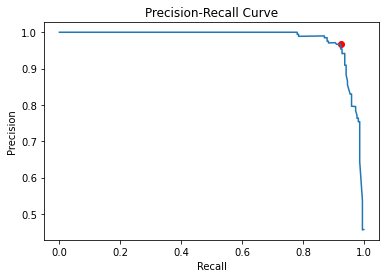

In [28]:
# Run models
res = {}
# generate the dataset to save the model result (df_test)
X_train, y_train, X_test, y_test, df_test = train_test_generation(df_feature, features_to_use, byr_idx_cols,
                                 test_size, random_state)
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)

for model in model_list:
    res_m = run_model(df_feature, features_to_use, byr_idx_cols, cv,
                     model, model_params[model], threshold_setting, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]
    

In [29]:
df_test.head()

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred
831,0.0,400395435606.0,0.0,0.0,0.0,0.0,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.016051,0.005495
124,0.0,400039020549.0,1.0,5.0,1.0,0.0,1.251997e+05,51004.25000,0.000000,0.000000,15166.666992,6956.212402,0.0,1.0,0.140503,7.384277e+04,0.718750,19199.132812,0.241793,0.181602
1580,1.0,11266308.0,2.0,3.0,1.0,0.0,2.058940e+05,157277.03125,0.002893,0.011116,985.714294,2414.497070,1.0,73.0,0.300049,2.061468e+09,0.502930,21034.810547,0.940647,0.996554
1611,1.0,16717214.0,1.0,3.0,1.0,0.0,1.203000e+06,0.00000,0.008247,0.000000,13000.000000,0.000000,1.0,88.0,0.736328,1.289384e+06,0.064331,27034.482422,0.946901,0.983596
700,0.0,400336632427.0,0.0,0.0,1.0,0.0,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.021614,0.011489


In [32]:
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)
df_test['rf_pred_label'] = df_test['rf_pred'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['xgb_pred_label'] = df_test['xgb_pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [33]:
pd.set_option('display.max_columns', None)
FP = df_test[(df_test['label'] == 1) & (df_test['rf_pred_label'] == 0)]
FP

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
1790,1.0,400035906189.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000e+00,0.000000,0.000000,0.076556,0.065280,0,0
2559,1.0,400656273670.0,1.0,3.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.108816,0.093296,0,0
2272,1.0,400228014436.0,2.0,5.0,1.0,0.0,103871.000000,0.000000,0.028076,0.000000,9500.000000,0.000000,0.0,2.0,0.214111,3.438462e+04,0.658203,10583.234375,0.259826,0.641906,0,1
1697,1.0,400014830092.0,1.0,1.0,0.0,0.0,558500.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.272217,1.949239e+09,0.000000,0.000000,0.338827,0.463175,0,0
1763,1.0,400028150180.0,1.0,4.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000e+00,0.000000,0.000000,0.132323,0.149980,0,0
2466,1.0,400366785130.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000e+00,0.000000,0.000000,0.076556,0.065280,0,0
1924,1.0,400080363354.0,1.0,1.0,1.0,0.0,119892.000000,40187.386719,0.049744,0.072754,24100.000000,16125.755859,0.0,2.0,0.126587,8.835710e+04,0.617188,13826.934570,0.465203,0.636416,0,1
1701,1.0,400015260140.0,1.0,4.0,0.0,0.0,996500.000000,0.000000,0.000000,0.000000,5000.000000,0.000000,0.0,1.0,0.298828,1.028823e+05,0.168213,653.970520,0.181307,0.045004,0,0
2127,1.0,400159656898.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.021614,0.011489,0,0
2478,1.0,400380111938.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.021614,0.011489,0,0


In [38]:
FN = df_test[(df_test['label'] == 0) & (df_test['rf_pred_label'] == 1)]
FN

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,id_new_ip3_4m,id_ip3_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
1190,0.0,410401821745.0,1.0,3.0,1.0,0.0,2.527500e+04,5865.737305,0.000000,0.000000,5725.000000,3335.697021,1.0,1.0,0.333740,9.958135e+04,0.907227,7987.686523,0.602043,0.879560,1,1
408,0.0,400199073717.0,1.0,2.0,1.0,0.0,8.572370e+04,60846.769531,0.013908,0.037476,13076.922852,2630.049316,0.0,5.0,0.296875,1.835671e+05,0.727051,34319.800781,0.865074,0.991302,1,1
1244,0.0,410421189243.0,1.0,2.0,1.0,0.0,2.893400e+06,21650.634766,0.000000,0.000000,6900.000000,0.000000,0.0,2.0,0.376709,1.934668e+06,0.163818,15263.701172,0.511963,0.161167,1,0
1456,0.0,410476740249.0,1.0,1.0,1.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.0,0.000000,0.000000e+00,0.000000,0.000000,0.562196,0.695237,1,1
463,0.0,400227555922.0,1.0,1.0,1.0,0.0,9.336634e+04,24636.730469,0.000000,0.000000,36333.332031,2357.022705,0.0,51.0,0.179565,7.801877e+04,0.675293,15089.367188,0.869500,0.989258,1,1
1285,0.0,410433297872.0,1.0,1.0,1.0,1.0,1.406500e+06,341559.906250,0.000000,0.000000,22000.000000,4082.482910,1.0,1.0,0.203857,6.087684e+04,0.465820,17120.638672,0.537503,0.608704,1,1
1360,0.0,410452902319.0,1.0,1.0,1.0,0.0,4.377000e+05,0.000000,0.000000,0.000000,6900.000000,0.000000,1.0,7.0,0.782715,7.107347e+04,0.621094,2284.074951,0.720295,0.501905,1,1
1037,0.0,400647552529.0,2.0,2.0,1.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.0,0.000000,0.000000e+00,0.000000,0.000000,0.650798,0.838074,1,1
695,0.0,400334559149.0,1.0,2.0,1.0,0.0,1.376333e+05,26844.035156,0.000000,0.000000,33000.000000,0.000000,0.0,1.0,0.999512,1.052683e+05,0.771484,21608.927734,0.624205,0.827109,1,1
163,0.0,400066737244.0,1.0,2.0,0.0,0.0,6.836234e+04,56583.113281,0.000000,0.000000,16333.333008,2592.724854,1.0,1.0,0.291748,7.940941e+04,0.677246,18264.259766,0.549523,0.407188,1,0
